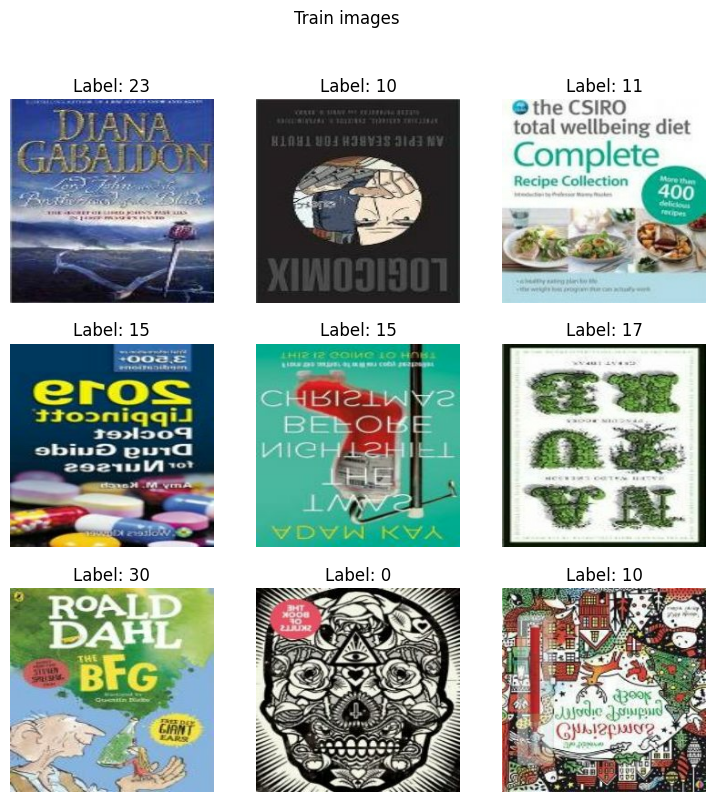

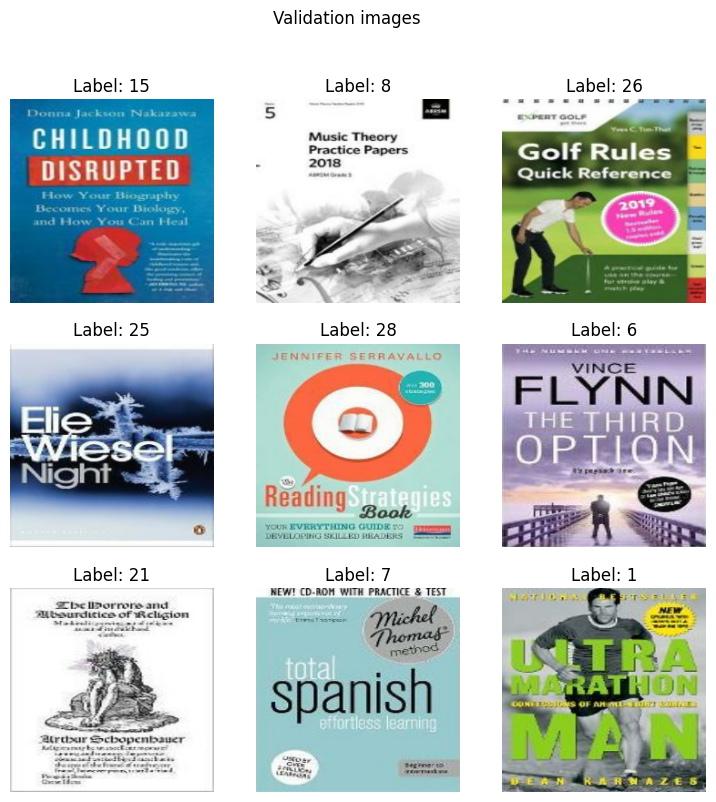

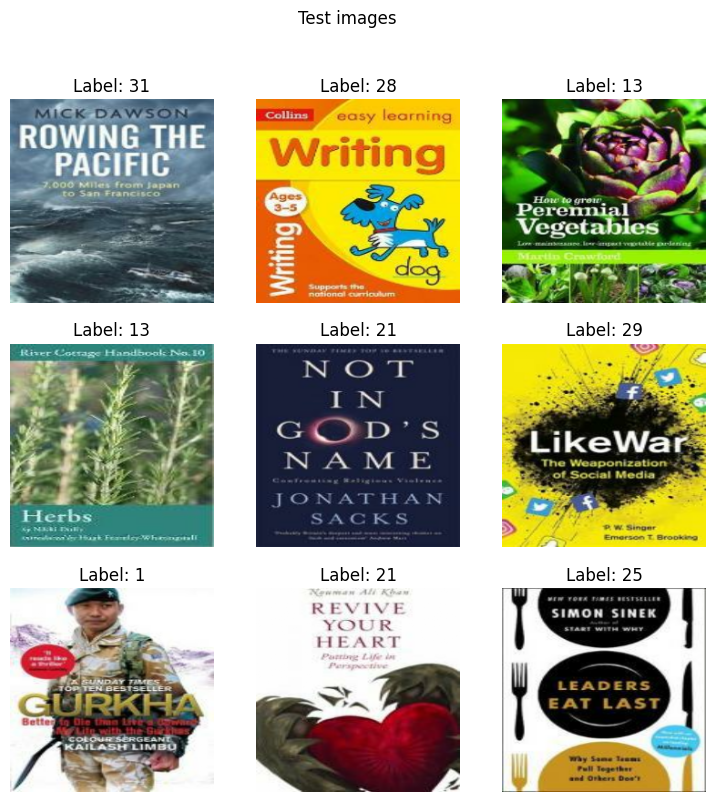

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from tensorflow.keras.losses import MeanSquaredError 
# this was for regression model. but convolut i need
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical


def load_and_preprocess_image(path):
    path = tf.strings.regex_replace(path, 'dataset/', 'C:/Users/frido/OneDrive/New folder/OneDrive/Desktop/archive (1)/book-covers/')
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range
    return image

def preprocess_data(df, num_classes):
    image_paths = df['img_paths'].values
    labels = df['category'].values
    
    # Encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(labels)
    encoded_Y = encoder.transform(labels)

    # Convert integers to one-hot encoding
    labels = tf.keras.utils.to_categorical(encoded_Y, num_classes=num_classes)
    
    return image_paths, labels

def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.map_fn(lambda img: tf.image.random_jpeg_quality(img, 75, 95), image)
    return image, label

def create_tf_dataset(image_paths, labels, batch_size):
    image_data = tf.data.Dataset.from_tensor_slices(image_paths)
    image_data = image_data.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    label_data = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_data, label_data))
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

def load_data(filename, num_classes, batch_size=32):
    df = pd.read_csv(filename)
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42) 

    train_images, train_labels = preprocess_data(train_df, num_classes)
    val_images, val_labels = preprocess_data(val_df, num_classes)
    test_images, test_labels = preprocess_data(test_df, num_classes)

    train_dataset = create_tf_dataset(train_images, train_labels, batch_size)
    val_dataset = create_tf_dataset(val_images, val_labels, batch_size)
    test_dataset = create_tf_dataset(test_images, test_labels, batch_size)

    train_dataset = train_dataset.map(data_augmentation)

    return train_dataset, val_dataset, test_dataset

def plot_images(dataset, title):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.suptitle(title)

    for images, labels in dataset.take(1):
        for i, (image, label) in enumerate(zip(images, labels)):
            if i >= 9:
                break
            ax = axes[i // 3, i % 3]
            ax.imshow(image.numpy())
            ax.set_title(f'Label: {np.argmax(label)}') # get the index of the maximum value, which is the class
            ax.axis('off')

num_classes = 33
batch_size = 32
train_dataset, val_dataset, test_dataset = load_data('main_dataset.csv', num_classes, batch_size)

plot_images(train_dataset, 'Train images')
plot_images(val_dataset, 'Validation images')
plot_images(test_dataset, 'Test images')
plt.show()


Epoch 1/2
611/611 [==============================] - 732s 1s/step - loss: 3.6882 - accuracy: 0.0301 - val_loss: 3.4970 - val_accuracy: 0.0281
Epoch 2/2
611/611 [==============================] - 728s 1s/step - loss: 3.4966 - accuracy: 0.0300 - val_loss: 3.4973 - val_accuracy: 0.0281


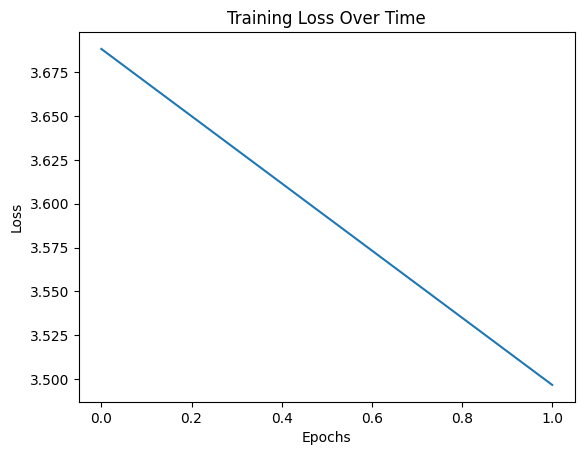

Evaluating on test data
204/204 [==============================] - 41s 197ms/step - loss: 3.4975 - accuracy: 0.0287
test loss: [3.4975078105926514, 0.028694184496998787]
204/204 [==============================] - 38s 182ms/step


In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def create_model():
    # Load ResNet50 model without its top layer and set input shape
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(33, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

# Plot the loss over time
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

# Evaluate on the test set
print("Evaluating on test data")
results = model.evaluate(test_dataset)
print("test loss:", results)

# Make predictions on the test set
test_images = []
test_labels = []
for image, label in test_dataset.unbatch().take(-1):
    test_images.append(image)
    test_labels.append(label)

test_images = np.array(test_images)
predicted_classes = np.argmax(model.predict(test_images), axis=-1)




204/204 [==============================] - 62s 197ms/step
Classification Report


c:\Users\frido\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\frido\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\frido\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                                precision    recall  f1-score   support

               Art-Photography       0.00      0.00      0.00       198
                     Biography       0.00      0.00      0.00       209
          Business-Finance-Law       0.03      1.00      0.06       187
               Childrens-Books       0.00      0.00      0.00       211
                     Computing       0.00      0.00      0.00       195
                Crafts-Hobbies       0.00      0.00      0.00       187
                Crime-Thriller       0.00      0.00      0.00       209
        Dictionaries-Languages       0.00      0.00      0.00       209
                 Entertainment       0.00      0.00      0.00       211
                    Food-Drink       0.00      0.00      0.00       208
    Graphic-Novels-Anime-Manga       0.00      0.00      0.00       217
                        Health       0.00      0.00      0.00       199
           History-Archaeology       0.00      0.00      0.00  

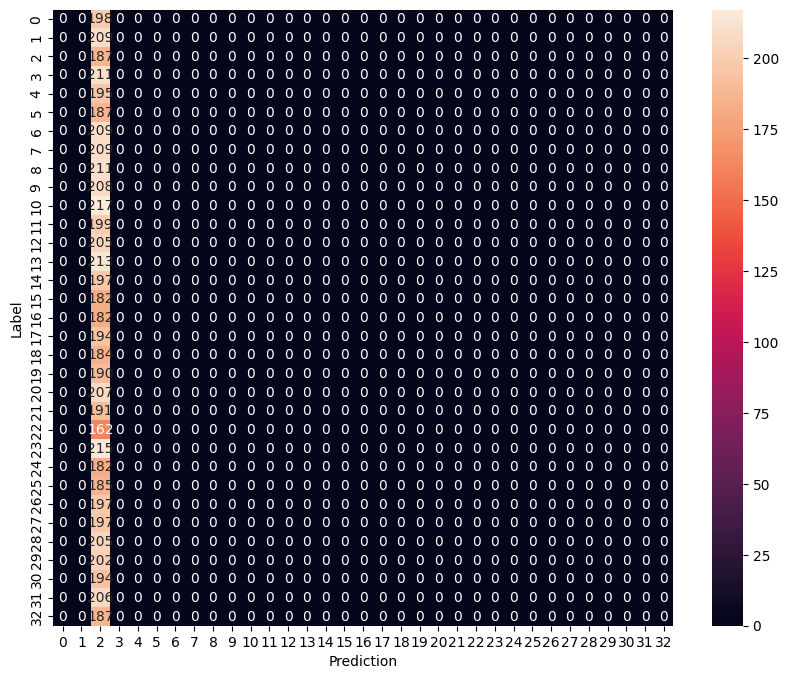

In [27]:
# Plot the confusion matrix
from sklearn.metrics import  classification_report, confusion_matrix
import seaborn as sns

# Get the class predictions
predicted_classes = np.argmax(model.predict(test_dataset), axis=1)

# Convert one-hot encoded test labels to class labels
test_labels_classes = np.argmax(test_labels, axis=1)


class_names = ['Art-Photography', 'Biography', 'Business-Finance-Law', 'Childrens-Books', 'Computing', 'Crafts-Hobbies', 'Crime-Thriller', 'Dictionaries-Languages', 'Entertainment', 'Food-Drink','Graphic-Novels-Anime-Manga', 'Health', 'History-Archaeology', 'Home-Garden', 'Humor', 'Medical', 'Mind-Body-Spirit', 'Natural-History', 'Personal-Development', 'Poetry-Drama', 'Reference', 'Religion', 'Romance', 'Science-Fiction-Fantasy-Horror', 'Science-Geography', 'Society-Social-Sciences', 'Sport','Stationery', 'Teaching-Resources-Education', 'Technology-Engineering', 'Teen-Young-Adult', 'Transport', 'Travel-Holiday-Guides']
# Print the classification report
print('Classification Report')
print(classification_report(test_labels_classes, predicted_classes, target_names=class_names))


# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(test_labels_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [28]:
def load_and_preprocess_single_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range
    image = tf.expand_dims(image, 0)  # add batch dimension
    return image

# load the image
image = load_and_preprocess_single_image('C:/Users/frido/Downloads/archive (1)/photo_2023-06-20_11-03-34.jpg')

# predict the class
pred = model.predict(image)
print(pred)
# convert prediction to genre
predicted_genre_index = tf.argmax(pred, axis=1).numpy()[0]  # get the index of the max value
predicted_genre = lookup_layer.get_vocabulary()[predicted_genre_index]
print(lookup_layer.get_vocabulary())
print(f"The predicted genre is: {predicted_genre}")


1/1 [==============================] - 0s 86ms/step
[[0.02947292 0.03014707 0.0314668  0.03055553 0.03053619 0.03064169
  0.03015041 0.02967608 0.02905762 0.02941911 0.02973713 0.03062459
  0.03052751 0.02962837 0.03041289 0.03077956 0.03130665 0.03037654
  0.03049042 0.03044515 0.02984865 0.0306469  0.03136013 0.02992054
  0.02999889 0.0306583  0.03068833 0.0295609  0.02940093 0.02987465
  0.0308505  0.03081136 0.03092764]]
['[UNK]', 'Mind-Body-Spirit', 'Business-Finance-Law', 'Romance', 'Travel-Holiday-Guides', 'Medical', 'Crafts-Hobbies', 'Society-Social-Sciences', 'Humour', 'Transport', 'Teen-Young-Adult', 'Religion', 'Personal-Development', 'Health', 'Sport', 'Childrens-Books', 'Poetry-Drama', 'History-Archaeology', 'Natural-History', 'Crime-Thriller', 'Computing', 'Biography', 'Science-Geography', 'Science-Fiction-Fantasy-Horror', 'Reference', 'Technology-Engineering', 'Stationery', 'Art-Photography', 'Home-Garden', 'Graphic-Novels-Anime-Manga', 'Dictionaries-Languages', 'Food-Dr